In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Functions

In [2]:
def eta(u, T, cmplx): # this can handle real and complex
# the thresholding function used in ISTA
  if cmplx:
    return np.exp(1j*np.angle(u)) * (np.maximum(np.abs(u)-T, 0))
  else:
      return (u - T)*(u >= T) + (u + T)*(u <= -T)

In [3]:

def make_data(sys_param, tfs):
    # noise is boolean, true if noise
    # fading is boolean, true if fading; fading is real or complex depending on the value of cmplx
    # sigma is the variance of the noise given
    # dual_bs is a boolean, true for 2 BS case
    # cmplx is boolean, true if it wants complex values

    # returns A_1, A_2, x_uL, y_uL1, y_uL2, L1, L2
    # if it is a single base station then the unneeded values will be returned as zero

    # unwrap the arguments
    n, N, k, sigma = sys_param
    noise, fading, dual_bs, cmplx = tfs
    
    # always only makes one x-vector
    x_uL = np.zeros((N, 1), dtype=np.complex_)
    idx_nonzero_entries = np.random.permutation(N)[0:k]
    x_uL[idx_nonzero_entries] = 1

    # if there's two base stations, these values will be overridden
    A_2 = 0
    L2 = 0
    y_uL2 = 0

    if cmplx:  # complex single BS
        # sensing matrices
        A_1 = np.sqrt(1 / (2 * n)) * np.random.randn(n, N) + 1j * np.sqrt(1 / (2 * n)) * np.random.randn(n, N)
        # finding thresholding parameter
        _, Lambda1, _ = np.linalg.svd(A_1)
        L1 = np.max(Lambda1) + 1
        # creating complex noise
        w1 = np.sqrt((sigma ** 2) / 2) * np.random.randn(n).reshape(-1, 1) + 1j * np.sqrt(
            (sigma ** 2) / 2) * np.random.randn(n).reshape(-1, 1)

        if dual_bs:  # create second pair of matrices
            A_1 = np.sqrt(1 / (4 * n)) * np.random.randn(n, N) + 1j * np.sqrt(1 / (4 * n)) * np.random.randn(n, N)
            A_2 = A_1.copy()
            _, Lambda1, _ = np.linalg.svd(A_1)
            L1 = np.max(Lambda1) + 1
            L2 = L1
            w2 = np.sqrt((sigma ** 2) / 2) * np.random.randn(n).reshape(-1, 1) + 1j * np.sqrt(
                (sigma ** 2) / 2) * np.random.randn(n).reshape(-1, 1)

        if fading:  # complex fading
            # creating fading effects -> CN(0,1)
            h_uL1 = np.sqrt(1 / 2) * np.random.random(N) + np.sqrt(1 / 2) * 1j * np.random.random(N)
            h_uL1 = np.diag(h_uL1)
            # sensing matrix with fading applied
            A_1 = A_1 @ h_uL1
            # finding thresholding parameter
            _, Lambda1, _ = np.linalg.svd(A_1)
            L1 = np.max(Lambda1) + 1

            if noise:  # single BS, complex fading and noise
                y_uL1 = A_1 @ x_uL + w1
            else:
                y_uL1 = A_1 @ x_uL

            if dual_bs:  # complex fading, 2 BS
                # create second set of things
                # creating fading effects -> CN(0,1)
                h_uL2 = np.sqrt(1 / 2) * np.random.random(N) + np.sqrt(1 / 2) * 1j * np.random.random(N)
                h_uL2 = np.diag(h_uL2)
                # sensing matrix with fading applied
                A_2 = A_2 @ h_uL2
                # finding thresholding parameter
                _, Lambda1, _ = np.linalg.svd(A_2)
                L2 = np.max(Lambda1) + 1

                if noise: 
                    y_uL2 = A_2 @ x_uL + w2
                else:
                    y_uL2 = A_2 @ x_uL

        else:  # complex, no fading
            if noise:
                y_uL1 = A_1 @ x_uL + w1
            else:
                y_uL1 = A_1 @ x_uL

            if dual_bs:
                if noise:
                    y_uL2 = A_2 @ x_uL + w2
                else:
                    y_uL2 = A_2 @ x_uL

    else:  # real valued
        # sensing matrices
        A_1 = np.sqrt(1 / n) * np.random.randn(n, N)
        # finding thresholding parameter
        _, Lambda1, _ = np.linalg.svd(A_1)
        L1 = np.max(Lambda1) + 1
        # creating noise
        w1 = sigma * np.random.randn(n).reshape(-1, 1)

        if dual_bs:
            A_1 = np.sqrt(1 / (2*n)) * np.random.randn(n, N)
            A_2 = A_1.copy()
            _, Lambda1, _ = np.linalg.svd(A_1)
            L1 = np.max(Lambda1) + 1
            L2 = L1
            w2 = sigma * np.random.randn(n).reshape(-1, 1)

        if fading:  # real valued, 1 BS fading
            # creating fading effects -> N(0,1)
            h_uL1 = np.random.rayleigh(size=N)
            h_uL1 = np.diag(h_uL1)
            # sensing matrix with fading applied
            A_1 = A_1 @ h_uL1
            # finding thresholding parameter
            _, Lambda1, _ = np.linalg.svd(A_1)
            L1 = np.max(Lambda1) + 1

            if noise:
                y_uL1 = A_1 @ x_uL + w1
            else:
                y_uL1 = A_1 @ x_uL

            if dual_bs:
                # creating fading effects -> CN(0,1)
                h_uL2 = np.random.rayleigh(size=N)
                h_uL2 = np.diag(h_uL2)
                # sensing matrix with fading applied
                A_2 = A_2 @ h_uL2
                # finding thresholding parameter
                _, Lambda1, _ = np.linalg.svd(A_2)
                L2 = np.max(Lambda1) + 1
                if noise:
                    y_uL2 = A_2 @ x_uL + w1
                else:
                    y_uL2 = A_2 @ x_uL

        else:  # no fading, real values
            if noise:
                y_uL1 = A_1 @ x_uL + w1
            else:
                y_uL1 = A_1 @ x_uL

            if dual_bs:
                if noise:
                    y_uL2 = A_2 @ x_uL + w2
                else:
                    y_uL2 = A_2 @ x_uL

    return A_1, A_2, x_uL, y_uL1, y_uL2, L1, L2

In [4]:
def ist_mse_iter(sys_param, tfs, num_iterations, avg):
# sys_param holds n,N,k vals and sigma
# tfs (true-falses) holds system information
# returns the MSE per iterations

    alpha = .25  # predetermined for the 1 BS case
    n,N,k,sigma = sys_param
    noise, fading, dual_bs, cmplx = tfs

    mse_per_iteration = np.zeros(num_iterations)
    
    for j in range(avg):
      A1, A2, x_uL, y_uL1, y_uL2, L1, L2 = make_data(sys_param, tfs)  # make the data needed
      
      if dual_bs: # concatenate the necessary vectors then proceed
      # you could probably work this into the make_data function
          A1 = np.vstack((A1,A2))
          y_uL1 = np.vstack((y_uL1,y_uL2))
          _, Lambda2, _ = np.linalg.svd(A1)
          L1 = np.max(Lambda2) + 1
          # alpha = alpha*2 # double the single BS case
          alpha = alpha / 2 # half the single BS case

          ### doing the averaging method ###
          # y_uL1 = .5*(y_uL1 + y_uL2)

      if cmplx:
          xHt = np.zeros(x_uL.shape, dtype=np.complex_)
          # these are Q, W from the introduction
          x_weight = np.eye(N) - (1/L1)*(A1.conj().T @ A1)
          y_weight = (1/L1)*A1.conj().T
              
      else:
          xHt = np.zeros(x_uL.shape)
          # these are Q, W from the introduction
          x_weight = np.eye(N) - (1/L1)*(A1.T @ A1)
          y_weight = (1/L1)*A1.T

      # this part is same for complex or real
      for idx in range(num_iterations):
          update = (x_weight @ xHt) + (y_weight @ y_uL1)
          xHt = eta(update, alpha/L1, cmplx)
          
          mse_per_iteration[idx] += (1/N) * np.sum(np.abs(x_uL - xHt)**2)

        # return the average  
    return mse_per_iteration / avg

In [5]:
def ist_mse_snr(sys_param, tfs, num_iterations, avg):
# sys_param holds n,N,k vals and sigma
# tfs (true-falses) holds system information
# returns the MSE for some SNRs
    alpha = .25  # predetermined for the 1 BS case
    n,N,k,sigma = sys_param
    noise, fading, dual_bs, cmplx = tfs

    if dual_bs:
      alpha = alpha/2

     # creating noise matrix
    SNRdB = np.array([-12,-10, -5, 1, 5, 10, 20])
    if dual_bs:
      SNRs = (10**(SNRdB/10))*2*n
    else:
      SNRs = (10**(SNRdB/10))*n
    sigmas = 1/(np.sqrt(SNRs))

    if cmplx:  # create the mse matrix
      mse_per_iteration = np.zeros(len(sigmas), dtype=np.complex_)
    else:
      mse_per_iteration = np.zeros(len(sigmas))

    cnt = 0
    for sig in sigmas:
        mse = 0
        for i in range(avg):
          sys_param = (n,N,k,sig)
          A1, A2, x_uL, y_uL1, y_uL2, L1, L2 = make_data(sys_param, tfs)  # make the data needed

          if dual_bs: # concatenate the necessary vectors then proceed
            # you could probably work this into the make_data function
            A1 = np.vstack((A1,A2))
            y_uL1 = np.vstack((y_uL1,y_uL2))

          if cmplx:
            xHt = np.zeros(x_uL.shape, dtype=np.complex_)
            x_weight = np.eye(N) - (1/L1)*(A1.conj().T @ A1)
            y_weight = (1/L1)*A1.conj().T
              
          else:
            xHt = np.zeros(x_uL.shape)
            x_weight = np.eye(N) - (1/L1)*(A1.T @ A1)
            y_weight = (1/L1)*A1.T


          # IST
          for idx_iter in range(num_iterations):
            update = (x_weight @ xHt) + (y_weight @ y_uL1)
            xHt = eta(update, alpha/L1, cmplx)
          mse_per_iteration[cnt] += (1/N) * np.sum(np.abs(x_uL - xHt)**2)
        cnt += 1

    return mse_per_iteration / avg

In [6]:
def ist_md_fa(sys_param, tfs, num_iterations, avg, threshold):

   # unwrap the input tuples
    n,N,k,sigma = sys_param
    noise, fading, dual_bs, cmplx = tfs
    
    ista_fa = np.zeros(num_iterations)
    ista_md = np.zeros(num_iterations)
      

    for j in range(avg):
      # create new data
      A1, A2, x_uL, y_uL1, y_uL2, L1, L2 = make_data(sys_param, tfs)

      if dual_bs: # concatenate the necessary vectors then proceed
          A1 = np.vstack((A1,A2))
          y_uL1 = np.vstack((y_uL1,y_uL2))

      # find active users
      real_users = np.where(x_uL == 1)[0]

      if cmplx:
        x_weight = np.eye(N) - (1/L1)*(A1.conj().T @ A1)
        y_weight = (1/L1)*A1.conj().T
        xHt = np.zeros(x_uL.shape, dtype=np.complex_)
      else:
        x_weight = np.eye(N) - (1/L1)*(A1.T @ A1)
        y_weight = (1/L1)*A1.T
        xHt = np.zeros(x_uL.shape)

      for idx in range(num_iterations):
          update = (x_weight @ xHt) + (y_weight @ y_uL1)
          xHt = eta(update, alpha/L1, cmplx)

          # find detection errors
          xHt_user_guess = np.where(abs(xHt) > threshold)[0]
          fa = np.setdiff1d(xHt_user_guess, real_users)  # returns the guessed values that aren't in real ones. aka False Alarm
          md = np.setdiff1d(real_users, xHt_user_guess)  # real values that aren't in the guessed ones. aka Misdetection

          ista_fa[idx] += len(fa)
          ista_md[idx] += len(md)


    # divide it out by the number of averages
    ista_md = ista_md / avg
    ista_fa = ista_fa / avg

    return ista_md, ista_fa

In [7]:
def ist_md_fa_snr(sys_param, tfs, num_iterations, avg, threshold):

  # unwrap parameters
  n,N,k,sigma = sys_param
  noise, fading, dual_bs, cmplx = tfs

   # creating noise matrix
  SNRdB = np.array([-12,-10, -5, 1, 5, 10, 20])
  if dual_bs:
    SNRs = (10**(SNRdB/10))*2*n
  else:
    SNRs = (10**(SNRdB/10))*n
  sigmas = 1/(np.sqrt(SNRs))

  ista_snr_fa = np.zeros(len(sigmas))
  ista_snr_md = np.zeros(len(sigmas))

  cnt = 0 
  for sig in sigmas:
    for j in range(avg):
      # create new data
      sys_param = (n,N,k,sig)
      A1, A2, x_uL, y_uL1, y_uL2, L1, L2 = make_data(sys_param, tfs)
      
      if dual_bs: # concatenate the necessary vectors then proceed
          A1 = np.vstack((A1,A2))
          y_uL1 = np.vstack((y_uL1,y_uL2))

      real_users = np.where(x_uL == 1)[0]

      if cmplx:
        x_weight = np.eye(N) - (1/L1)*(A1.conj().T @ A1)
        y_weight = (1/L1)*A1.conj().T
        xHt = np.zeros(x_uL.shape, dtype=np.complex_)
      else:
        x_weight = np.eye(N) - (1/L1)*(A1.T @ A1)
        y_weight = (1/L1)*A1.T
        xHt = np.zeros(x_uL.shape)

      for idx in range(num_iterations):
          update = (x_weight @ xHt) + (y_weight @ y_uL1)
          xHt = eta(update, alpha/L1, cmplx)

      # find detection errors
      xHt_user_guess = np.where(abs(xHt) > threshold)[0]
      fa = np.setdiff1d(xHt_user_guess, real_users)  # returns the guessed values that aren't in real ones. aka False Alarm
      md = np.setdiff1d(real_users, xHt_user_guess)  # real values that aren't in the guessed ones. aka Misdetection
      ista_snr_fa[cnt] += len(fa)
      ista_snr_md[cnt] += len(md)

    cnt += 1

  # divide it out by the number of averages
  ista_snr_md = ista_snr_md / avg
  ista_snr_fa = ista_snr_fa / avg

  return ista_snr_md, ista_snr_fa

# Neat ratio changes

In [ ]:
k = 40
N = 1024
n = 270

num_iterations = 15
num_avg = 10
alpha = .25
threshold = .4 ## used for MD, FA

dual_bs = False
cmplx = True
fading = True
noise = True

snr_dB = 5   # enter an SNR in dB

SNR = (10**(snr_dB/10))*n
sigma = 1/(np.sqrt(SNR))
tfs = (noise,fading,dual_bs,cmplx)
dual_bs = False
# finding the standard deviation of the noise
SNR = (10**(snr_dB/10))*n
sigma = 1/(np.sqrt(SNR))
sys_param = (n,N,k,sigma)
tfs = (noise,fading,dual_bs,cmplx)
original = ist_mse_iter(sys_param, tfs, num_iterations, num_avg)
print(np.array2string(original, separator=','))

[0.0353864 ,0.03305024,0.03143103,0.03025024,0.02935913,0.02866752,
 0.02812184,0.02768623,0.0273347 ,0.02704893,0.02681463,0.02661973,
 0.02645702,0.02632061,0.02620604]


In [ ]:
# n/N = .263
# k/N = .078

# double the sparsity!
k = 40*2
N = 1024
n = 270

num_iterations = 15
num_avg = 10
alpha = .25
threshold = .4 ## used for MD, FA

dual_bs = False
cmplx = True
fading = True
noise = True

snr_dB = 5   # enter an SNR in dB

SNR = (10**(snr_dB/10))*n
sigma = 1/(np.sqrt(SNR))
tfs = (noise,fading,dual_bs,cmplx)
sys_param = (n,N,k,sigma)
double_sparse = ist_mse_iter(sys_param, tfs, num_iterations, num_avg)
print(np.array2string(double_sparse, separator=','))

[0.069949  ,0.06572842,0.06300772,0.06107108,0.05960814,0.0584664 ,
 0.05755323,0.05680836,0.05619032,0.05567124,0.05523258,0.05485792,
 0.05453589,0.05425852,0.0540196 ]


In [ ]:
# n/N = .263
# k/N = .019

# half the sparsity!
k = int(40/2)
N = 1024
n = 270

num_iterations = 15
num_avg = 10
alpha = .25
threshold = .4 ## used for MD, FA

dual_bs = False
cmplx = True
fading = True
noise = True

snr_dB = 5   # enter an SNR in dB

SNR = (10**(snr_dB/10))*n
sigma = 1/(np.sqrt(SNR))
tfs = (noise,fading,dual_bs,cmplx)
sys_param = (n,N,k,sigma)
half_sparse = ist_mse_iter(sys_param, tfs, num_iterations, num_avg)
print(np.array2string(half_sparse, separator=','))

[0.01781129,0.01661554,0.01575194,0.0151099 ,0.01462093,0.01424245,
 0.01394527,0.0137091 ,0.01351949,0.01336595,0.01324071,0.01313787,
 0.01305302,0.01298263,0.01292398]


In [ ]:
k = 40*10
N = 1024
n = 270

num_iterations = 15
num_avg = 10
alpha = .25
threshold = .4 ## used for MD, FA

dual_bs = False
cmplx = True
fading = True
noise = True

snr_dB = 5   # enter an SNR in dB

SNR = (10**(snr_dB/10))*n
sigma = 1/(np.sqrt(SNR))
tfs = (noise,fading,dual_bs,cmplx)
dual_bs = False
# finding the standard deviation of the noise
SNR = (10**(snr_dB/10))*n
sigma = 1/(np.sqrt(SNR))
sys_param = (n,N,k,sigma)
tfs = (noise,fading,dual_bs,cmplx)
ten = ist_mse_iter(sys_param, tfs, num_iterations, num_avg)
print(np.array2string(ten, separator=','))

[0.34475952,0.33281905,0.32770298,0.32521436,0.32391205,0.32329967,
 0.32310445,0.32315921,0.32335118,0.32363463,0.32397223,0.32434763,
 0.32474059,0.32513379,0.32552823]


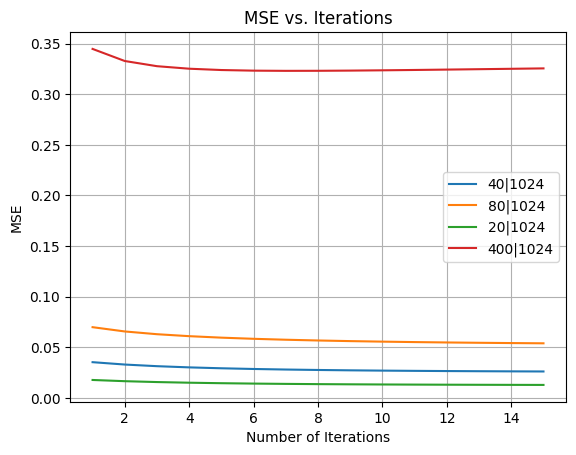

In [ ]:
plt.figure()
plt.plot(range(1,16), original, label='40|1024')
plt.plot(range(1,16), double_sparse, label='80|1024')
plt.plot(range(1,16), half_sparse, label='20|1024')
plt.plot(range(1,16), ten, label='400|1024')
plt.grid(True, which='both')
plt.legend()
plt.xlabel("Number of Iterations")
plt.title("MSE vs. Iterations")
plt.ylabel("MSE")
plt.show()

In [ ]:
amp_half = [0.01324346,0.01131945,0.00936138,0.0081801 ,0.00712816,0.00630427,
 0.00576401,0.0052637 ,0.00492213,0.00462258,0.00436481,0.00414685,
 0.00398237,0.00384496,0.00374317]
amp_double = [0.05868067,0.05461918,0.04919712,0.04595101,0.04294404,0.04079232,
 0.0389443 ,0.03720814,0.03588712,0.03456279,0.03353476,0.03265828,
 0.03200164,0.03119624,0.03061968]
amp_orig = [0.02837921,0.02515599,0.02197906,0.01958064,0.01767352,0.01628073,
 0.01510869,0.01408144,0.0133708 ,0.01260917,0.01204209,0.01156677,
 0.01118349,0.01080638,0.01038322]
amp_ten = [0.33746252,0.35305445,0.35983764,0.36585554,0.36784536,0.37172628,
 0.37566554,0.38053545,0.38119988,0.38080673,0.38096043,0.37974686,
 0.37815593,0.37841944,0.37804041]

Dashed line is AMP, solid line is ISTA


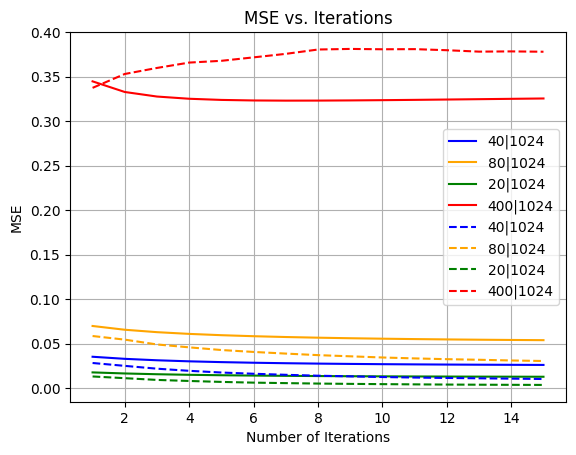

In [ ]:
print('Dashed line is AMP, solid line is ISTA')
plt.figure()
plt.plot(range(1,16), original, label='40|1024', color='blue')
plt.plot(range(1,16), double_sparse, label='80|1024', color='orange')
plt.plot(range(1,16), half_sparse, label='20|1024', color='green')
plt.plot(range(1,16), ten, label='400|1024', color='red')
plt.plot(range(1,16), amp_orig, label='40|1024', color='blue', linestyle='dashed')
plt.plot(range(1,16), amp_double, label='80|1024', color='orange', linestyle='dashed')
plt.plot(range(1,16), amp_half, label='20|1024', color='green', linestyle='dashed')
plt.plot(range(1,16), amp_ten, label='400|1024', color='red', linestyle='dashed')
plt.grid(True, which='both')
plt.legend()
plt.xlabel("Number of Iterations")
plt.title("MSE vs. Iterations")
plt.ylabel("MSE")
plt.show()

# maintianing ratios and testing

In [ ]:
# n/N = .1318
# k/N = .029
# multiply everything by 3 and see if you get the same results
k = 40*3
N = 1024*4
n = 270*2

num_iterations = 15
num_avg = 10
alpha = .25
threshold = .4 ## used for MD, FA

dual_bs = False
cmplx = True
fading = True
noise = True

snr_dB = 5   # enter an SNR in dB

SNR = (10**(snr_dB/10))*n
sigma = 1/(np.sqrt(SNR))
tfs = (noise,fading,dual_bs,cmplx)
sys_param = (n,N,k,sigma)
diff_ratio = ist_mse_iter(sys_param, tfs, num_iterations, num_avg)
print(np.array2string(diff_ratio, separator=','))

[0.02692161,0.02559485,0.0246765 ,0.02398608,0.02344243,0.02300143,
 0.02263697,0.02233179,0.02207298,0.02185178,0.02166141,0.02149645,
 0.02135262,0.02122644,0.0211153 ]


In [ ]:
# n/N = .263
# k/N = .039
# multiply everything by 3 and see if you get the same results
k = 40*3
N = 1024*3
n = 270*3

num_iterations = 15
num_avg = 10
alpha = .25
threshold = .4 ## used for MD, FA

dual_bs = False
cmplx = True
fading = True
noise = True

snr_dB = 5   # enter an SNR in dB

SNR = (10**(snr_dB/10))*n
sigma = 1/(np.sqrt(SNR))
tfs = (noise,fading,dual_bs,cmplx)
sys_param = (n,N,k,sigma)
triple_ratio = ist_mse_iter(sys_param, tfs, num_iterations, num_avg)
print(np.array2string(triple_ratio, separator=','))

[0.03520541,0.03275894,0.03105497,0.02980109,0.02884487,0.028098  ,
 0.02750471,0.02702745,0.02663956,0.0263207 ,0.02605673,0.0258372 ,
 0.0256537 ,0.02549961,0.02536952]


In [ ]:
# n/N = .263
# k/N = .039
# multiply everything by 2 and see if you get the same results
k = 40*2
N = 1024*2
n = 270*2

num_iterations = 15
num_avg = 10
alpha = .25
threshold = .4 ## used for MD, FA

dual_bs = False
cmplx = True
fading = True
noise = True

snr_dB = 5   # enter an SNR in dB

SNR = (10**(snr_dB/10))*n
sigma = 1/(np.sqrt(SNR))
tfs = (noise,fading,dual_bs,cmplx)

In [ ]:
dual_bs = False
# finding the standard deviation of the noise
SNR = (10**(snr_dB/10))*n
sigma = 1/(np.sqrt(SNR))
sys_param = (n,N,k,sigma)
tfs = (noise,fading,dual_bs,cmplx)
double_ratio = ist_mse_iter(sys_param, tfs, num_iterations, num_avg)
print(np.array2string(double_ratio, separator=','))

[0.03563331,0.03340306,0.03182899,0.03066247,0.029768  ,0.02906694,
 0.02850799,0.02805681,0.02768921,0.02738731,0.02713741,0.0269295 ,
 0.02675538,0.02660916,0.02648595]


In [ ]:
# n/N = .263
# k/N = .039
k = 40
N = 1024
n = 270

num_iterations = 15
num_avg = 10
alpha = .25
threshold = .4 ## used for MD, FA

dual_bs = False
cmplx = True
fading = True
noise = True

snr_dB = 5   # enter an SNR in dB

SNR = (10**(snr_dB/10))*n
sigma = 1/(np.sqrt(SNR))
tfs = (noise,fading,dual_bs,cmplx)

In [ ]:
dual_bs = False
# finding the standard deviation of the noise
SNR = (10**(snr_dB/10))*n
sigma = 1/(np.sqrt(SNR))
sys_param = (n,N,k,sigma)
tfs = (noise,fading,dual_bs,cmplx)
original = ist_mse_iter(sys_param, tfs, num_iterations, num_avg)
print(np.array2string(original, separator=','))

[0.03521215,0.03278691,0.03110071,0.02986173,0.02891889,0.02818369,
 0.02760139,0.02713474,0.02675649,0.02644575,0.02618767,0.025973  ,
 0.02579399,0.02564329,0.02551493]


In [ ]:
original = [0.03521215,0.03278691,0.03110071,0.02986173,0.02891889,0.02818369,
 0.02760139,0.02713474,0.02675649,0.02644575,0.02618767,0.025973  ,
 0.02579399,0.02564329,0.02551493]
double_ratio = [0.03563331,0.03340306,0.03182899,0.03066247,0.029768  ,0.02906694,
 0.02850799,0.02805681,0.02768921,0.02738731,0.02713741,0.0269295 ,
 0.02675538,0.02660916,0.02648595]
triple_ratio = [0.03520541,0.03275894,0.03105497,0.02980109,0.02884487,0.028098  ,
 0.02750471,0.02702745,0.02663956,0.0263207 ,0.02605673,0.0258372 ,
 0.0256537 ,0.02549961,0.02536952]

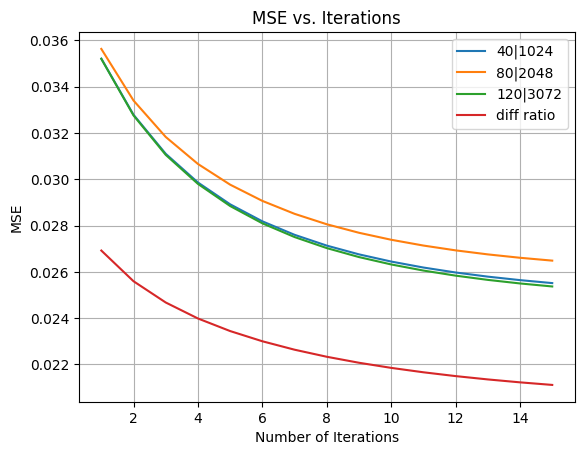

In [ ]:
plt.figure()
plt.plot(range(1,16), original, label='40|1024')
plt.plot(range(1,16), double_ratio, label='80|2048')
plt.plot(range(1,16), triple_ratio, label='120|3072')
plt.plot(range(1,16), diff_ratio, label='diff ratio')
plt.grid(True, which='both')
plt.legend()
plt.xlabel("Number of Iterations")
plt.title("MSE vs. Iterations")
plt.ylabel("MSE")
plt.show()

# Analyzing ISTA

In [8]:
k = 40
N = 1024
n = 270

num_iterations = 15
num_avg = 100
alpha = .25
threshold = .2 ## used for MD, FA

dual_bs = False
cmplx = True
fading =True
noise = True

snr_dB = 5   # enter an SNR in dB

# finding the standard deviation of the noise
SNR = (10**(snr_dB/10))*n
sigma = 1/(np.sqrt(SNR))

sys_param = (n,N,k,sigma)
tfs = (noise,fading,dual_bs,cmplx)

In [ ]:
%%time
mse_iter1 = ist_mse_iter(sys_param, tfs, num_iterations, num_avg)
print(np.array2string(mse_iter1, separator=','))

[0.03546566,0.03316428,0.0315538 ,0.03036673,0.02946207,0.02875587,
 0.02819469,0.02774274,0.02737482,0.02707272,0.02682298,0.02661524,
 0.0264416 ,0.0262958 ,0.02617285]
CPU times: user 26min 34s, sys: 5min 38s, total: 32min 13s
Wall time: 18min 26s


MSE vs. Iterations

k: 40
[0.03537898 0.03303184 0.0313962  0.03019365 0.02927687 0.02856246
 0.02799467 0.02753688 0.02716415 0.02685862 0.02660597 0.02639483
 0.02621808 0.02606945 0.02594406]
k: 60
[0.05317868 0.04998554 0.04782726 0.04626765 0.04509438 0.04417848
 0.04345036 0.04286404 0.04238627 0.04199235 0.04166429 0.04138977
 0.04115766 0.04096151 0.04079413]
k: 150
[0.13129207 0.12507742 0.12141603 0.11895566 0.11716503 0.11579951
 0.11472986 0.11387721 0.11318229 0.11260773 0.11212885 0.11172994
 0.11139389 0.11110568 0.11085906]
k: 300
[0.26323987 0.25404127 0.24953571 0.24699749 0.24547991 0.24452672
 0.24392234 0.24353782 0.24331155 0.24320135 0.24316117 0.24318157
 0.24324091 0.24333053 0.24343883]
k: 500
[0.43155654 0.41767491 0.41216443 0.40987229 0.40902414 0.40891757
 0.40926271 0.40984563 0.41055496 0.41130491 0.41209998 0.41289891
 0.41369362 0.41446449 0.41521837]
k: 800
[0.68752514 0.66509911 0.65713929 0.65452938 0.65432927 0.65531455
 0.65688789 0.65874782 0.66073955 0.66277494 0.6

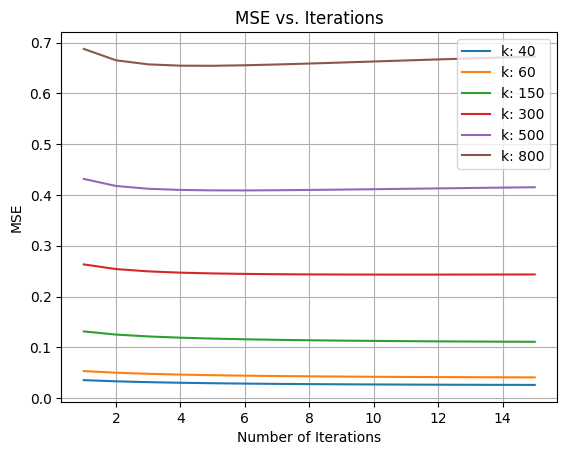

In [ ]:
plt.figure()
for k_val in [40, 60, 150, 300, 500, 800]:
  sys_param = (n,N,k_val,sigma)
  mse_iter1 = ist_mse_iter(sys_param, tfs, num_iterations, num_avg)
  plt.plot(range(1,num_iterations+1), mse_iter1, label=f'k: {k_val}')
  print(f'k: {k_val}\n{mse_iter1}')
plt.title("MSE vs. Iterations")
plt.xlabel("Number of Iterations")
plt.ylabel("MSE")
plt.grid(True, which='both')
plt.legend()
plt.show()


If there is only noise, this works great. But once fading or complex number are involved, ISTA plateuas at ~.025

In [ ]:
dual_bs = False
# finding the standard deviation of the noise
SNR = (10**(snr_dB/10))*n
sigma = 1/(np.sqrt(SNR))
sys_param = (n,N,k,sigma)
tfs = (noise,fading,dual_bs,cmplx)
mse_iter1 = ist_mse_iter(sys_param, tfs, num_iterations, num_avg)
print(np.array2string(mse_iter1, separator=','))

dual_bs = True
# finding the standard deviation of the noise
SNR = (10**(snr_dB/10))*2*n  ### adjusted for 2 BS SNR to be correct
sigma = 1/(np.sqrt(SNR))
sys_param = (n,N,k,sigma)
tfs = (noise,fading,dual_bs,cmplx)
## push it farther beause it is still decreasing - 40 iter
mse_iter2 = ist_mse_iter(sys_param, tfs, 60, num_avg)
print(np.array2string(mse_iter2, separator=','))

[0.03522731,0.03280961,0.03113197,0.0299038 ,0.02897318,0.02825172,
 0.02768144,0.02722429,0.02685384,0.02655069,0.02630104,0.02609385,
 0.02592105,0.02577634,0.0256548 ,0.02555225,0.02546527,0.02539142,
 0.02532848,0.02527473,0.02522876,0.02518938,0.0251556 ,0.02512656,
 0.02510156,0.02507999,0.02506134,0.02504521,0.02503124,0.02501913]
[0.0318533 ,0.02918047,0.02759638,0.02648207,0.0256239 ,0.02492617,
 0.02433886,0.02383259,0.02338864,0.02299431,0.02264051,0.0223206 ,
 0.02202961,0.02176348,0.02151894,0.02129343,0.0210848 ,0.02089116,
 0.0207109 ,0.02054271,0.02038541,0.02023799,0.02009957,0.01996938,
 0.01984671,0.01973095,0.01962155,0.01951802,0.01941991,0.01932683,
 0.0192384 ,0.01915429,0.01907424,0.01899795,0.01892519,0.0188557 ,
 0.01878929,0.01872577,0.01866496,0.01860669,0.01855083,0.01849724,
 0.01844578,0.01839634,0.01834881,0.01830307,0.01825905,0.01821665,
 0.01817579,0.01813639,0.01809838,0.01806168,0.01802625,0.01799201,
 0.01795892,0.01792691,0.01789595,0.01786598,0.0

In [ ]:
# dual_bs = False
# # finding the standard deviation of the noise
# SNR = (10**(snr_dB/10))*n
# sigma = 1/(np.sqrt(SNR))
# sys_param = (n,N,k,sigma)
# tfs = (noise,fading,dual_bs,cmplx)
# mse_per_iter1 = ist_mse_iter(sys_param, tfs, num_iterations, num_avg)
# print(np.array2string(mse_per_iter1, separator=','))

# dual_bs = True
# SNR = (10**(snr_dB/10))*2*n  ### adjusted for 2 BS SNR to be correct
# sigma = 1/(np.sqrt(SNR))
# sys_param = (n,N,k,sigma)
# tfs = (noise,fading,dual_bs,cmplx)
# mse_per_iter2 = ist_mse_iter(sys_param, tfs, num_iterations, num_avg)
# print(np.array2string(mse_per_iter2, separator=','))

I halved the alpha of the single BS for the dual BS case
Noise: True | Fading: True | Dual BS: True | Complex: True
SNR: 5
Num_iter: 30
Averaged over 30 trials


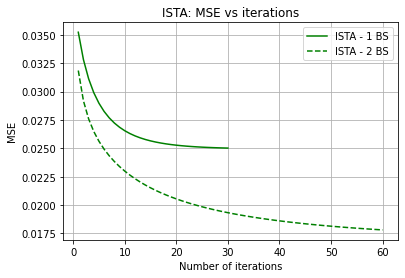

1 BS: [0.03522731 0.03280961 0.03113197 0.0299038  0.02897318 0.02825172
 0.02768144 0.02722429 0.02685384 0.02655069 0.02630104 0.02609385
 0.02592105 0.02577634 0.0256548  0.02555225 0.02546527 0.02539142
 0.02532848 0.02527473 0.02522876 0.02518938 0.0251556  0.02512656
 0.02510156 0.02507999 0.02506134 0.02504521 0.02503124 0.02501913]
2 BS: [0.0318533  0.02918047 0.02759638 0.02648207 0.0256239  0.02492617
 0.02433886 0.02383259 0.02338864 0.02299431 0.02264051 0.0223206
 0.02202961 0.02176348 0.02151894 0.02129343 0.0210848  0.02089116
 0.0207109  0.02054271 0.02038541 0.02023799 0.02009957 0.01996938
 0.01984671 0.01973095 0.01962155 0.01951802 0.01941991 0.01932683
 0.0192384  0.01915429 0.01907424 0.01899795 0.01892519 0.0188557
 0.01878929 0.01872577 0.01866496 0.01860669 0.01855083 0.01849724
 0.01844578 0.01839634 0.01834881 0.01830307 0.01825905 0.01821665
 0.01817579 0.01813639 0.01809838 0.01806168 0.01802625 0.01799201
 0.01795892 0.01792691 0.01789595 0.01786598 0.0178

In [ ]:
print('I halved the alpha of the single BS for the dual BS case')
print(f'Noise: {noise} | Fading: {fading} | Dual BS: {dual_bs} | Complex: {cmplx}')
if noise:
  print(f'SNR: {snr_dB}')

print(f'Num_iter: {num_iterations}')
print(f'Averaged over {num_avg} trials')
plt.figure()
plt.plot(range(1,len(mse_iter1)+1), abs(mse_iter1),label="ISTA - 1 BS", color='green')
plt.plot(range(1,len(mse_iter2)+1), abs(mse_iter2),label="ISTA - 2 BS", color='green', linestyle='dashed')
plt.title("ISTA: MSE vs iterations")
plt.xlabel("Number of iterations")
plt.ylabel("MSE")
plt.legend()
plt.grid(True, which='both')
plt.show()

print(f'1 BS: {abs(mse_iter1)}')
print(f'2 BS: {abs(mse_iter2)}')

MSE vs. SNR

In [ ]:
SNRdB = np.array([-12,-10, -5, 1, 5, 10, 20])
SNRs = (10**(SNRdB/10))*n
sigmas = 1/(np.sqrt(SNRs))

/usr/local/lib/python3.9/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


k: 40
[0.02859704+0.j 0.02676818+0.j 0.02547583+0.j 0.02606849+0.j
 0.02569808+0.j 0.02694089+0.j 0.02651418+0.j]
k: 60
[0.04534616+0.j 0.04234604+0.j 0.04124273+0.j 0.04007862+0.j
 0.04067333+0.j 0.04055111+0.j 0.04029374+0.j]
k: 150
[0.11830182+0.j 0.11742451+0.j 0.11239217+0.j 0.11310441+0.j
 0.11221434+0.j 0.11272354+0.j 0.11361026+0.j]
k: 300
[0.24482061+0.j 0.2463039 +0.j 0.24363388+0.j 0.24285477+0.j
 0.23986777+0.j 0.24112379+0.j 0.23907632+0.j]
k: 500
[0.41831393+0.j 0.41646229+0.j 0.41167813+0.j 0.41866189+0.j
 0.41417563+0.j 0.41318987+0.j 0.41352939+0.j]
k: 800
[0.67117533+0.j 0.66929328+0.j 0.67210685+0.j 0.67551128+0.j
 0.67060473+0.j 0.66796894+0.j 0.66589862+0.j]
k: 1024
[0.86544635+0.j 0.85904704+0.j 0.85699276+0.j 0.85480182+0.j
 0.85774211+0.j 0.85937278+0.j 0.86110146+0.j]


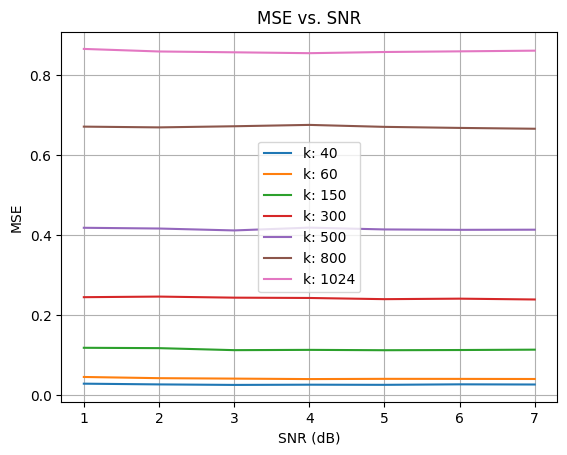

In [ ]:
plt.figure()
for k_val in [40, 60, 150, 300, 500, 800, 1024]:
  sys_param = (n,N,k_val,sigma)
  mse_iter1 = ist_mse_snr(sys_param, tfs, num_iterations, num_avg)
  plt.plot(range(1,len(mse_iter1)+1), mse_iter1, label=f'k: {k_val}')
  print(f'k: {k_val}\n{mse_iter1}')
plt.title("MSE vs. SNR")
plt.xlabel("SNR (dB)")
plt.ylabel("MSE")
plt.grid(True, which='both')
plt.legend()
plt.show()

In [ ]:
# this function has a preset list of SNRdB that corresponds to the one in the code cell above
dual_bs = False
tfs = (noise, fading, dual_bs, cmplx)
mse_snr1 = ist_mse_snr(sys_param, tfs, num_iterations, num_avg)
dual_bs = True
tfs = (noise, fading, dual_bs, cmplx)
mse_snr2 = ist_mse_snr(sys_param, tfs, num_iterations, num_avg)

KeyboardInterrupt: ignored

In [ ]:
print(f'Noise: {noise} | Fading: {fading} | Dual BS: {dual_bs} | Complex: {cmplx}')

print(f'Num_iter: {num_iterations}')
print(f'Averaged over {num_avg} trials')
plt.figure()
plt.plot(SNRdB, abs(mse_snr1),label="ISTA - 1 BS", color='green')
plt.plot(SNRdB, abs(mse_snr2),label="ISTA - 2 BS", color='green', linestyle='dashed')
plt.title("ISTA: MSE vs SNR")
plt.xlabel("SNR (dB)")
plt.ylabel("MSE")
plt.legend()
plt.grid(True, which='both')
plt.show()

print(f'1 BS: {abs(mse_snr1)}')
print(f'2 BS: {abs(mse_snr2)}')

MD, FA vs Iterations

MD | k: 40
[38.8 33.2 29.4 26.4 25.5 24.3 23.6 22.7 22.4 22.1 21.9 21.6 20.9 20.9
 20.9]
FA | k: 40
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
MD | k: 60
[57.2 48.8 44.6 42.3 40.5 38.6 37.6 36.5 35.5 35.  34.4 34.4 33.9 33.9
 33.9]
FA | k: 60
[0.  0.1 0.2 0.4 0.5 0.5 0.6 0.5 0.4 0.5 0.4 0.2 0.2 0.2 0.2]
MD | k: 150
[137.6 121.5 114.  109.1 105.  102.5 101.3 100.3  99.6  98.8  98.5  98.4
  98.1  98.   98.1]
FA | k: 150
[ 0.7  6.2 10.6 13.6 14.4 14.9 15.6 14.9 15.  14.4 14.2 13.9 13.8 14.
 13.4]
MD | k: 300
[263.9 234.6 222.2 216.2 213.7 212.4 211.6 211.3 211.4 211.4 211.1 211.6
 212.1 211.8 212. ]
FA | k: 300
[11.7 33.  42.1 46.2 49.  50.  50.  49.8 48.9 48.4 48.3 47.9 47.1 46.9
 46.6]
MD | k: 500
[417.  373.2 359.5 354.3 351.4 351.5 352.6 353.8 354.7 355.8 356.8 357.6
 358.6 360.3 361.3]
FA | k: 500
[34.5 57.7 66.5 68.5 68.6 68.2 67.4 66.5 65.6 64.5 63.5 63.  62.3 61.8
 61. ]
MD | k: 800
[604.8 543.  527.  522.9 525.8 527.6 532.  535.2 539.5 542.8 545.9 549.
 552.  555.  557.6]
FA 

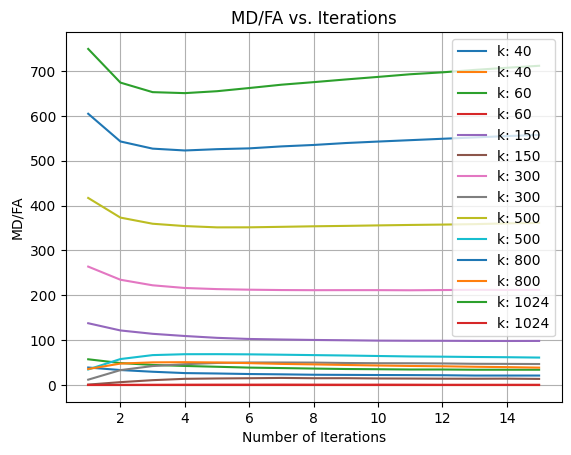

In [ ]:
plt.figure()
for k_val in [40, 60, 150, 300, 500, 800, 1024]:
  sys_param = (n,N,k_val,sigma)
  md_iter1, fa_iter1 = ist_md_fa(sys_param, tfs, num_iterations, num_avg, threshold)
  plt.plot(range(1,len(md_iter1)+1), md_iter1, label=f'k: {k_val}')
  print(f'MD | k: {k_val}\n{md_iter1}')
  plt.plot(range(1,len(fa_iter1)+1), fa_iter1, label=f'k: {k_val}')
  print(f'FA | k: {k_val}\n{fa_iter1}')
plt.title("MD/FA vs. Iterations")
plt.xlabel("Number of Iterations")
plt.ylabel("MD/FA")
plt.grid(True, which='both')
plt.legend()
plt.show()

In [ ]:
threshold = .1

dual_bs = False
SNR = (10**(snr_dB/10))*n
sigma = 1/(np.sqrt(SNR))
sys_param = (n,N,k,sigma)
tfs = (noise,fading,dual_bs,cmplx)
md_iter1, fa_iter1 = ist_md_fa(sys_param, tfs, num_iterations, num_avg, threshold)

dual_bs = True
SNR = (10**(snr_dB/10))*2*n  ### adjusted for 2 BS SNR to be correct
sigma = 1/(np.sqrt(SNR))
sys_param = (n,N,k,sigma)
tfs = (noise,fading,dual_bs,cmplx)
md_iter2, fa_iter2 = ist_md_fa(sys_param, tfs, num_iterations, num_avg, threshold)

In [ ]:
print("1 BS:")
print(f'FA: {fa_iter1}')
print(f'MD: {md_iter1}')
print('-------------------------------------------')
print("2 BS:")
print(f'FA: {fa_iter2}')
print(f'MD: {md_iter2}')

1 BS:
FA: [0.08 0.9  1.43 1.55 1.47 1.33 1.18 0.99 0.87 0.72 0.62 0.57 0.47 0.41
 0.39]
MD: [31.84 25.74 23.41 22.15 21.18 20.64 20.21 19.98 19.79 19.62 19.54 19.45
 19.38 19.32 19.29]
-------------------------------------------
2 BS:
FA: [0.01 0.26 0.41 0.46 0.37 0.32 0.25 0.18 0.15 0.14 0.13 0.12 0.11 0.08
 0.08]
MD: [31.58 24.27 21.23 19.85 18.94 18.37 17.83 17.54 17.2  17.04 16.91 16.85
 16.77 16.72 16.64]


Noise: True | Fading: True | Dual BS: True | Complex: True
SNR: 5
Num_iter: 30 | Avg: 30
Threshold: 0.2


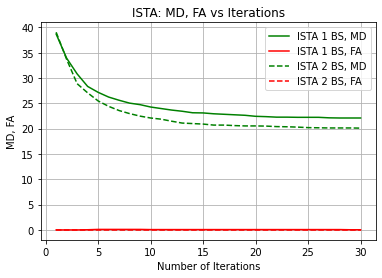

1 BS, MD: [38.66666667,33.9       ,30.8       ,28.33333333,27.16666667,26.23333333,
 25.6       ,25.03333333,24.73333333,24.26666667,23.96666667,23.66666667,
 23.43333333,23.13333333,23.1       ,22.93333333,22.83333333,22.73333333,
 22.63333333,22.43333333,22.36666667,22.26666667,22.26666667,22.23333333,
 22.23333333,22.23333333,22.13333333,22.1       ,22.1       ,22.1       ]
1 BS, FA: [0.        ,0.        ,0.        ,0.03333333,0.1       ,0.1       ,
 0.1       ,0.1       ,0.1       ,0.06666667,0.06666667,0.06666667,
 0.06666667,0.06666667,0.06666667,0.06666667,0.06666667,0.06666667,
 0.06666667,0.06666667,0.06666667,0.06666667,0.06666667,0.06666667,
 0.06666667,0.06666667,0.06666667,0.06666667,0.03333333,0.03333333]
2 BS, MD: [39.03333333,33.66666667,28.86666667,27.06666667,25.46666667,24.4       ,
 23.56666667,22.96666667,22.46666667,22.1       ,21.86666667,21.46666667,
 21.1       ,21.        ,20.9       ,20.7       ,20.7       ,20.6       ,
 20.53333333,20.53333333,20.5       ,2

In [ ]:
print(f'Noise: {noise} | Fading: {fading} | Dual BS: {dual_bs} | Complex: {cmplx}')
if noise:
  print(f'SNR: {snr_dB}')

print(f'Num_iter: {num_iterations} | Avg: {num_avg}')
print(f'Threshold: {threshold}')
plt.figure()
plt.plot(range(1,num_iterations+1), abs(md_iter1),label="ISTA 1 BS, MD", color='green')
plt.plot(range(1,num_iterations+1), abs(fa_iter1),label="ISTA 1 BS, FA", color='red')
plt.plot(range(1,num_iterations+1), abs(md_iter2),label="ISTA 2 BS, MD", color='green', linestyle='dashed')
plt.plot(range(1,num_iterations+1), abs(fa_iter2),label="ISTA 2 BS, FA", color='red', linestyle='dashed')
plt.title("ISTA: MD, FA vs Iterations")
plt.xlabel("Number of Iterations")
plt.ylabel("MD, FA")
plt.legend()
plt.grid(True, which='both')
plt.show()

print(f'1 BS, MD: {np.array2string(abs(md_iter1),separator=",")}')
print(f'1 BS, FA: {np.array2string(abs(fa_iter1),separator=",")}')
print(f'2 BS, MD: {np.array2string(abs(md_iter2),separator=",")}')
print(f'2 BS, FA: {np.array2string(abs(fa_iter2),separator=",")}')

MD, FA vs SNR

In [ ]:
dual_bs = False
tfs = (noise, fading, dual_bs, cmplx)
md_snr1, fa_snr1 = ist_md_fa_snr(sys_param, tfs, num_iterations, num_avg, threshold)

dual_bs = True
tfs = (noise, fading, dual_bs, cmplx)
md_snr2, fa_snr2 = ist_md_fa_snr(sys_param, tfs, num_iterations, num_avg, threshold)

In [ ]:
print("1 BS:")
print(f'FA: {fa_snr1}')
print(f'MD: {md_snr1}')
print('-------------------------------------------')
print("2 BS:")
print(f'FA: {fa_snr2}')
print(f'MD: {md_snr2}')

1 BS:
FA: [30.86 15.52  2.62  0.65  0.4   0.38  0.25]
MD: [21.14 20.86 19.41 18.87 19.04 18.85 19.46]
-------------------------------------------
2 BS:
FA: [7.7  2.62 0.21 0.2  0.06 0.1  0.13]
MD: [17.63 17.35 17.26 17.27 16.62 16.95 17.22]


Noise: True | Fading: True | Dual BS: True | Complex: True
Num_iter: 30 | Avg: 30
Threshold: 0.2


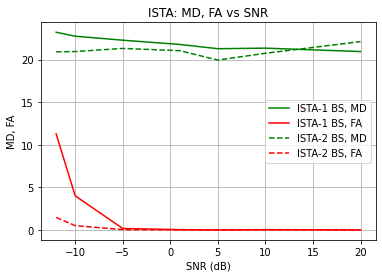

1 BS, MD: [23.2       ,22.73333333,22.26666667,21.76666667,21.26666667,21.33333333,
 20.93333333]
1 BS, FA: [11.26666667, 4.        , 0.16666667, 0.03333333, 0.        , 0.03333333,
  0.        ]
2 BS, MD: [20.9       ,20.93333333,21.3       ,21.03333333,19.93333333,20.73333333,
 22.1       ]
2 BS, FA: [1.46666667,0.5       ,0.03333333,0.        ,0.        ,0.        ,
 0.        ]


In [ ]:
print(f'Noise: {noise} | Fading: {fading} | Dual BS: {dual_bs} | Complex: {cmplx}')

print(f'Num_iter: {num_iterations} | Avg: {num_avg}')
print(f'Threshold: {threshold}')
plt.figure()
plt.plot(SNRdB, abs(md_snr1),label="ISTA-1 BS, MD", color='green')
plt.plot(SNRdB, abs(fa_snr1),label="ISTA-1 BS, FA", color='red')
plt.plot(SNRdB, abs(md_snr2),label="ISTA-2 BS, MD", color='green', linestyle='dashed')
plt.plot(SNRdB, abs(fa_snr2),label="ISTA-2 BS, FA", color='red', linestyle='dashed')
plt.title("ISTA: MD, FA vs SNR")
plt.xlabel("SNR (dB)")
plt.ylabel("MD, FA")
plt.legend()
plt.grid(True, which='both')
plt.show()

print(f'1 BS, MD: {np.array2string(abs(md_snr1),separator=",")}')
print(f'1 BS, FA: {np.array2string(abs(fa_snr1),separator=",")}')

print(f'2 BS, MD: {np.array2string(abs(md_snr2),separator=",")}')
print(f'2 BS, FA: {np.array2string(abs(fa_snr2),separator=",")}')